# Testing Stock Fetcher 

## Imports 

In [1]:
# Reload Custom Modules 
import importlib
import src.beta_vae
import src.data_fetching 
import src.portfolio
importlib.reload(src.beta_vae)
importlib.reload(src.data_fetching)
importlib.reload(src.portfolio)

<module 'src.portfolio' from 'c:\\Users\\jairp\\OneDrive\\Desktop_remote\\HEC Montreal\\4. Fall 2024\\Deep Learning II\\Project\\StockDiversifier\\src\\portfolio.py'>

In [2]:
# General 
import os 
import json 
import random 
from tqdm.notebook import tqdm

# Data Science
import optuna 
import numpy as np 
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# PyTorch
import torch

# Custom Classes 
from src.beta_vae import Encoder
from src.beta_vae import Decoder
from src.beta_vae import BetaVAE
from src.portfolio import Portfolio

# Custom Functions
from src.beta_vae import create_data_loaders
from src.beta_vae import create_single_data_loader
from src.beta_vae import objective
from src.beta_vae import train_beta_vae
from src.beta_vae import get_embeddings
from src.beta_vae import generate_embeddings_dict
from src.portfolio import fetch_and_calculate_returns
from src.data_fetching import scrape_sp500_wikipedia
from src.data_fetching import fetch_stock_data
from src.data_fetching import prepare_data_for_vae

In [10]:
custom_tickers = [
    'PLTR',  # Palantir Technologies Inc. (Technology)
    'COIN',  # Coinbase Global, Inc. (Financials)
    'WDAY',  # Workday, Inc. (Technology)
    'TTD',   # The Trade Desk, Inc. (Technology)
    'APO',   # Apollo Global Management, Inc. (Financials)
    'MELI',  # MercadoLibre, Inc. (Consumer Discretionary)
    'NVO',   # Novo Nordisk A/S (Healthcare)
    'ICON',  # Icon PLC (Healthcare)
    'TSM',   # Taiwan Semiconductor Manufacturing Company Limited (Technology)
    'SKX',   # Skechers U.S.A., Inc. (Consumer Discretionary)
    'BAYRY', # Bayer AG (Healthcare)
    'DISCK', # Discovery, Inc. (Communication Services)
    'FNV',   # Franco-Nevada Corporation (Materials)
    'SHOP',  # Shopify Inc. (Technology)
    'SQ',    # Square, Inc. (Technology)
    'UBER',  # Uber Technologies, Inc. (Industrials)
    'ZM',    # Zoom Video Communications, Inc. (Technology)
    'TWLO',  # Twilio Inc. (Technology)
    'MRNA',  # Moderna, Inc. (Healthcare)
    'WDAY',  # Workday, Inc. (Technology)
    'DOCU',  # DocuSign, Inc. (Technology)
    'VEEV',  # Veeva Systems Inc. (Healthcare)
    'LULU',  # Lululemon Athletica Inc. (Consumer Discretionary)
    'ROKU',  # Roku, Inc. (Communication Services)
    'CRWD',  # CrowdStrike Holdings, Inc. (Technology)
    'SNOW',  # Snowflake Inc. (Technology)
    'NET',   # Cloudflare, Inc. (Technology)
    'PINS',  # Pinterest, Inc. (Communication Services)
    'ETSY',  # Etsy, Inc. (Consumer Discretionary)
    'SPOT'   # Spotify Technology S.A. (Communication Services)
]

## Fetching the data 

In [15]:
REFETCH = False 

# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

if REFETCH:
    # Fetch data for all sp500 + custom tickers
    stock_data, sector_mapping, industry_mapping = fetch_stock_data(sp500_df, custom_tickers, 
                                                                    period = "1y", interval = "1wk",
                                                                    savepath="data_raw/stock_data.csv") # Fetch data
else: 
    # read data from file
    stock_data = pd.read_csv("data_raw/stock_data.csv", index_col=0).reset_index()

# Prepare data for VAE
stock_data_vae = prepare_data_for_vae(stock_data) 


In [4]:
stock_data.head()

,Ticker,Company Name,Market Cap,Sector,Industry,Open Price,Close Price,High Price,Low Price,Last Close,52 Week High,52 Week Low,Last Month Volatility,52 Week Volatility,Yearly Dividend Rate,Last Year Return Rate,Sector_encoded,Industry_encoded
0,NWSA,News Corporation,1.726500e+10,Communication Services,Entertainment,25.930760,26.045643,30.040001,21.357464,29.514999,30.040001,21.357462,0.201953,0.207794,0.20,0.328255,0,0
1,AAPL,Apple Inc.,3.479355e+12,Information Technology,Consumer Electronics,201.028515,202.235961,237.228999,163.488440,230.179993,237.229001,163.488440,0.226025,0.225397,1.00,0.218756,1,1
2,CMS,CMS Energy Corporation,2.068339e+10,Utilities,Utilities - Regulated Electric,61.201230,61.396029,71.852481,53.738413,69.224998,71.852482,53.738413,0.160289,0.168458,2.06,0.247739,2,2
3,ENPH,"Enphase Energy, Inc.",9.497347e+09,Information Technology,Solar,109.958868,109.344245,141.630005,58.330002,70.294998,141.630005,58.330002,0.683696,0.644609,0.00,-0.281237,1,3
4,WM,"Waste Management, Inc.",9.076090e+10,Industrials,Waste Management,201.623019,202.600001,226.839996,166.214828,226.130005,226.839996,166.333060,0.201495,0.180754,3.00,0.338651,3,4


In [16]:
# Display the data 
print(stock_data_vae.head())

     Market Cap  Open Price  Close Price  High Price   Low Price  Last Close  \
0  1.726500e+10   25.930760    26.045643   30.040001   21.357464   29.514999   
1  3.479355e+12  201.028515   202.235961  237.228999  163.488440  230.179993   
2  2.068339e+10   61.201230    61.396029   71.852481   53.738413   69.224998   
3  9.497347e+09  109.958868   109.344245  141.630005   58.330002   70.294998   
4  9.076090e+10  201.623019   202.600001  226.839996  166.214828  226.130005   

   52 Week High  52 Week Low  Last Month Volatility  52 Week Volatility  ...  \
0     30.040001    21.357462               0.201953            0.207794  ...   
1    237.229001   163.488440               0.226025            0.225397  ...   
2     71.852482    53.738413               0.160289            0.168458  ...   
3    141.630005    58.330002               0.683696            0.644609  ...   
4    226.839996   166.333060               0.201495            0.180754  ...   

   Industry_Travel Services  Industry_

In [17]:
# Print number of columns for stock_data 
print(len(stock_data.columns))

# Print number of columns in total 
print(len(stock_data_vae.columns))

# Print total number of rows 
print(len(stock_data_vae))

# Print the data types of the columns
print(stock_data_vae.dtypes)

18
145
519
Market Cap                              float64
Open Price                              float64
Close Price                             float64
High Price                              float64
Low Price                               float64
                                         ...   
Industry_Utilities - Regulated Gas      float64
Industry_Utilities - Regulated Water    float64
Industry_Utilities - Renewable          float64
Industry_Waste Management               float64
Industry_Other                          float64
Length: 145, dtype: object


In [18]:
print(stock_data_vae.columns)

Index(['Market Cap', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Last Close', '52 Week High', '52 Week Low', 'Last Month Volatility',
       '52 Week Volatility',
       ...
       'Industry_Travel Services', 'Industry_Trucking',
       'Industry_Utilities - Diversified',
       'Industry_Utilities - Independent Power Producers',
       'Industry_Utilities - Regulated Electric',
       'Industry_Utilities - Regulated Gas',
       'Industry_Utilities - Regulated Water',
       'Industry_Utilities - Renewable', 'Industry_Waste Management',
       'Industry_Other'],
      dtype='object', length=145)


### Check for any NA's

In [19]:
# Check if any columns have nas
print(stock_data_vae.isna().sum().sum())

# Produce a list of columns with nas, and the amount for each 
print(stock_data_vae.columns[stock_data_vae.isna().any()].tolist())

# Calculate the proportion of nas in the stock_data_vae dataframe for each column with nas 
# only for the columns with nas
nas_proportion = stock_data_vae.isna().mean()
print(nas_proportion[stock_data_vae.columns[stock_data_vae.isna().any()].tolist()])

0
[]
Series([], dtype: float64)


## Fitting the $\beta$-VAE

### Data Preparation

In [20]:
# Normalize the stock data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(stock_data_vae)

# Convert the normalized data to PyTorch tensors
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(tensor_data)

# Check the DataLoader output
next(iter(train_loader))[0].shape  # Shape of one batch of data

torch.Size([64, 145])

### Hyperparameter Tunning

In [ ]:
# Define the file path for storing the best parameters
best_params_file = "config/best_params.json"

REWRITE = True 
if REWRITE:
    # Delete previous best_params file
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

# Check if the best_params file exists
if os.path.exists(best_params_file):
    # Load the best parameters from the file
    with open(best_params_file, "r") as f:
        best_params = json.load(f)
    print("Loaded best parameters from file:", best_params)
    
else:
    # File doesn't exist, run the Optuna study
    print("Best parameters file not found. Running Optuna study...")
    
    # Assuming `normalized_data` is the prepared dataset
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, normalized_data), n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters found:", best_params)

    # Save the best parameters to a JSON file
    os.makedirs(os.path.dirname(best_params_file), exist_ok=True)  # Create directory if it doesn't exist
    with open(best_params_file, "w") as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {best_params_file}")

### Model Training

In [22]:

# File path for the saved model
model_path = "models/beta_vae_with_metadata.pth"

RETRAIN = True
if RETRAIN:
    # Delete previous model file
    if os.path.exists(model_path):
        os.remove(model_path)

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Model found at {model_path}. Loading the model...")

    # Load model state and metadata
    model_metadata = torch.load(model_path)

    # Recreate the model using the saved metadata
    beta_vae = BetaVAE(
        input_dim=model_metadata["input_dim"],
        latent_dim=model_metadata["latent_dim"],
        beta=model_metadata["beta"]
    )
    beta_vae.load_state_dict(model_metadata["model_state"])
    beta_vae.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model not found at {model_path}. Training a new model...")

    # Assuming you use the best hyperparameters from Optuna
    latent_dim = best_params['latent_dim']
    beta = best_params['beta']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    input_dim = stock_data_vae.shape[1]

    # Recreate DataLoaders with the best batch size
    train_loader, val_loader, test_loader = create_data_loaders(tensor_data, batch_size=batch_size)

    # Initialize and train the model
    beta_vae = BetaVAE(input_dim=input_dim, latent_dim=latent_dim, beta=beta)
    train_beta_vae(beta_vae, train_loader, val_loader, num_epochs=50, learning_rate=learning_rate)

    # Save the trained model with metadata
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Ensure the directory exists
    model_metadata = {
        "model_state": beta_vae.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "beta": beta
    }
    torch.save(model_metadata, model_path)
    print(f"Model trained and saved to {model_path}.")

Model not found at models/beta_vae_with_metadata.pth. Training a new model...
Epoch [1/50], Training Loss: 167.5034
Epoch [1/50], Validation Loss: 125.8878
Epoch [2/50], Training Loss: 146.6011
Epoch [2/50], Validation Loss: 120.3968
Epoch [3/50], Training Loss: 144.7640
Epoch [3/50], Validation Loss: 120.1379
Epoch [4/50], Training Loss: 144.6951
Epoch [4/50], Validation Loss: 120.0853
Epoch [5/50], Training Loss: 144.6854
Epoch [5/50], Validation Loss: 120.1059
Epoch [6/50], Training Loss: 144.6905
Epoch [6/50], Validation Loss: 120.1004
Epoch [7/50], Training Loss: 144.6757
Epoch [7/50], Validation Loss: 120.1352
Epoch [8/50], Training Loss: 144.6750
Epoch [8/50], Validation Loss: 120.1207
Epoch [9/50], Training Loss: 144.6799
Epoch [9/50], Validation Loss: 120.1169
Epoch [10/50], Training Loss: 144.6830
Epoch [10/50], Validation Loss: 120.1173
Epoch [11/50], Training Loss: 144.6680
Epoch [11/50], Validation Loss: 120.1121
Epoch [12/50], Training Loss: 144.6745
Epoch [12/50], Valida

### Extract Embeddings for Train/Val/Test Data 

In [30]:
# Extract embeddings for the training data
train_embeddings = get_embeddings(beta_vae, train_loader)

# Optionally, extract embeddings for validation and test data
val_embeddings = get_embeddings(beta_vae, val_loader)
test_embeddings = get_embeddings(beta_vae, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)  # Should be (num_samples, latent_dim)
print("Val Embeddings Shape:", val_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)
print("Total number of embeddings:", train_embeddings.shape[0] + val_embeddings.shape[0] + test_embeddings.shape[0])

Train Embeddings Shape: torch.Size([363, 10])
Val Embeddings Shape: torch.Size([78, 10])
Test Embeddings Shape: torch.Size([78, 10])
Total number of embeddings: 519


### Extract Embeddings from the Stock Data 

In [24]:
# Generate embeddings for the stock data
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Display the embeddings for the first stock
print(f"Embeddings for the first stock ({stock_data['Ticker'].iloc[0]}):")
print(stock_embeddings[stock_data["Ticker"].iloc[0]])

Embeddings for the first stock (NWSA):
[-0.61101913 -0.23250365  0.39451164  2.1753526   0.08718762 -1.530631
  0.18049999  1.722393    1.0164107  -0.0205215 ]


### Portfolio Object Tests

#### Initialization

In [25]:
# Example returns for three stocks (numpy arrays of simulated returns)
returns_dict = {
    "AAPL": np.random.normal(0.001, 0.02, 1000),  # Apple
    "GOOGL": np.random.normal(0.0012, 0.025, 1000),  # Google
    "MSFT": np.random.normal(0.0008, 0.015, 1000)   # Microsoft
}

# Example weights (optional)
weights = {
    "AAPL": 0.4,
    "GOOGL": 0.4,
    "MSFT": 0.2
}

# Frequency of returns
frequency = "daily"

# Initialize the Portfolio object
portfolio = Portfolio(returns_dict=returns_dict, frequency=frequency, weights=weights, risk_free=0.00)

#### Attributes

In [26]:
# Print the tickers in the portfolio
print("Tickers:", portfolio.tickers)

# Print the raw returns dictionary
print("Raw Returns:")
for ticker, returns in portfolio.raw_returns.items():
    print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

# Print the covariance matrix
print("Covariance Matrix (Sigma):\n", portfolio.Sigma)

# Print the diagonal of the covariance matrix (sigmas)
print("Volatilities (sigmas):", portfolio.sigmas)

# Portfolio statistics
print("Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Portfolio Volatility:", portfolio.portfolio_volatility)
print("Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)

Tickers: ['AAPL', 'GOOGL', 'MSFT']
Raw Returns:
AAPL: [-0.00620228  0.04778985  0.03137896  0.01754592  0.03230325]...
GOOGL: [ 0.00413638 -0.00019267  0.0133766  -0.00302049  0.00548762]...
MSFT: [-0.0163386   0.00324299  0.0041497  -0.00127422  0.00688241]...
Covariance Matrix (Sigma):
 [[ 3.97078472e-04 -7.19355764e-06  9.48660051e-06]
 [-7.19355764e-06  5.90384591e-04  2.67775299e-05]
 [ 9.48660051e-06  2.67775299e-05  2.19150657e-04]]
Volatilities (sigmas): [0.01992683 0.02429783 0.01480374]
Portfolio Expected Return: 0.0011401078563401577
Portfolio Volatility: 0.013048388361032738
Portfolio Diversification Ratio: 1.582617760469942
Portfolio Sharpe Ratio: 0.08737537731057553


#### Calling Methods 

In [27]:
# Get covariance matrix as a DataFrame
cov_matrix_df = portfolio.get_covariance_matrix()
print("Covariance Matrix DataFrame:\n", cov_matrix_df)

# Get expected returns and volatilities (sigmas) as dictionaries
expected_returns, sigmas = portfolio.get_expected_returns_and_sigmas()
print("Expected Returns:", expected_returns)
print("Volatilities (sigmas):", sigmas)

# Get initial weights
init_weights = portfolio.get_weights()

# Optimize weights for maximum diversification
optimized_weights = portfolio.optimize_weights(method="max_div", update_weights=False)

# Update weights in the portfolio object after optimization
portfolio.optimize_weights(method="max_div", update_weights=True)

# Show weights before and after optimization 
print("Initial Weights:", init_weights)
print("Updated Weights:", portfolio.get_weights())

# Updated portfolio statistics after optimization
print("Updated Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Updated Portfolio Volatility:", portfolio.portfolio_volatility)
print("Updated Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Updated Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)

Covariance Matrix DataFrame:
            AAPL     GOOGL      MSFT
AAPL   0.000397 -0.000007  0.000009
GOOGL -0.000007  0.000590  0.000027
MSFT   0.000009  0.000027  0.000219
Expected Returns: {'AAPL': 0.0005666157652592288, 'GOOGL': 0.0023289890879755726, 'MSFT': -9.067042476881447e-05}
Volatilities (sigmas): {'AAPL': 0.019926827954695702, 'GOOGL': 0.024297830991497273, 'MSFT': 0.014803737936012485}
Initial Weights: {'AAPL': 0.4, 'GOOGL': 0.4, 'MSFT': 0.2}
Updated Weights: {'AAPL': 0.33163347720958286, 'GOOGL': 0.2617326434267977, 'MSFT': 0.4066338793636195}
Updated Portfolio Expected Return: 0.00076061156041541
Updated Portfolio Volatility: 0.011285438864728778
Updated Portfolio Diversification Ratio: 1.6824901887211166
Updated Portfolio Sharpe Ratio: 0.06739760584700041


#### Copying and updating the portfolio

In [28]:
# Example returns for additional stocks
returns_dict_new = {
    "AMZN": np.random.normal(0.0015, 0.03, 1000),  # Amazon
    "TSLA": np.random.normal(0.002, 0.05, 1000)   # Tesla
}

# Copy the existing portfolio
copied_portfolio = portfolio.copy_portfolio()
print("\n--- Copied Portfolio ---")
print("Tickers in copied portfolio:", copied_portfolio.tickers)
print("Weights in copied portfolio:", copied_portfolio.get_weights())
print("Expected Return (Copied):", copied_portfolio.portfolio_expected_return)
print("Volatility (Copied):", copied_portfolio.portfolio_volatility)
print("Diversification Ratio (Copied):", copied_portfolio.diversification_ratio)
print("Sharpe Ratio (Copied):", copied_portfolio.sharpe_ratio)

# Update portfolio: Add new tickers and remove an existing ticker
add_tickers = {"AMZN": returns_dict_new["AMZN"], "TSLA": returns_dict_new["TSLA"]}
remove_tickers = ["MSFT"]
new_weights = {"AAPL": 0.3, "GOOGL": 0.3, "AMZN": 0.2, "TSLA": 0.2}

# Update the portfolio 
portfolio.update_portfolio(add_tickers=add_tickers, remove_tickers=remove_tickers, new_weights=new_weights)

# Print updated portfolio attributes
print("\n--- Updated Portfolio ---")
print("Updated Tickers:", portfolio.tickers)
print("Updated Weights:", portfolio.get_weights())

# Portfolio statistics after update
print("Updated Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Updated Portfolio Volatility:", portfolio.portfolio_volatility)
print("Updated Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Updated Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)

# Optimize updated portfolio weights and compare again 
print("\n--- Optimization After Update ---")
portfolio.optimize_weights(method="max_div", update_weights=True)

# Updated portfolio statistics after optimization
print("Updated Tickers:", portfolio.tickers)
print("Updated Weights:", portfolio.get_weights())
print("Updated Portfolio Expected Return:", portfolio.portfolio_expected_return)
print("Updated Portfolio Volatility:", portfolio.portfolio_volatility)
print("Updated Portfolio Diversification Ratio:", portfolio.diversification_ratio)
print("Updated Portfolio Sharpe Ratio:", portfolio.sharpe_ratio)


--- Copied Portfolio ---
Tickers in copied portfolio: ['AAPL', 'GOOGL', 'MSFT']
Weights in copied portfolio: {'AAPL': 0.33163347720958286, 'GOOGL': 0.2617326434267977, 'MSFT': 0.4066338793636195}
Expected Return (Copied): 0.00076061156041541
Volatility (Copied): 0.011285438864728778
Diversification Ratio (Copied): 1.6824901887211166
Sharpe Ratio (Copied): 0.06739760584700041

--- Updated Portfolio ---
Updated Tickers: ['AAPL', 'GOOGL', 'AMZN', 'TSLA']
Updated Weights: {'AAPL': 0.3, 'GOOGL': 0.3, 'AMZN': 0.2, 'TSLA': 0.2}
Updated Portfolio Expected Return: 0.0017803463205018134
Updated Portfolio Volatility: 0.015360829855312553
Updated Portfolio Diversification Ratio: 1.9329942954059394
Updated Portfolio Sharpe Ratio: 0.06739760584700041

--- Optimization After Update ---
Updated Tickers: ['AAPL', 'GOOGL', 'AMZN', 'TSLA']
Updated Weights: {'AAPL': 0.36520445002935625, 'GOOGL': 0.29370084688968373, 'AMZN': 0.21346333391564729, 'TSLA': 0.12763136916531273}
Updated Portfolio Expected Retu

### Fetching Returns-Only Data For All Stocks

In [36]:
# Convert ndarray values to lists for JSON serialization
def serialize_ndarray(data_dict):
    return {key: (value.tolist() if isinstance(value, np.ndarray) else value) for key, value in data_dict.items()}

# Convert lists back to ndarrays if needed
def deserialize_ndarray(data_dict):
    return {key: (np.array(value) if isinstance(value, list) else value) for key, value in data_dict.items()}


In [37]:
LOAD_RETURNS = False 

if LOAD_RETURNS:
    # Load the returns from the file
    with open("data_raw/all_returns.json", "r") as f:
        all_returns = json.load(f)

    # Deserialize loaded data
    all_returns = deserialize_ndarray(all_returns)

    # Show the first few tickers and their returns
    print("First few tickers and their returns:")
    for ticker, returns in list(all_returns.items())[:5]:
        print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

else: 
    # Fetch and calculate returns for the all tickers in the S&P 500 and additional tickers
    all_tickers = stock_data["Ticker"].values.tolist()  # All S&P 500 tickers
    print(len(all_tickers))
    print(all_tickers[:5])

    # Fetch and calculate returns for all tickers
    all_returns = fetch_and_calculate_returns(all_tickers, period="1y", interval="1wk", price_column="Close")

    # Save the dictionary with the returns to a file using json 
    with open("data_raw/all_returns.json", "w") as f:
        json.dump(serialize_ndarray(all_returns), f, indent=4)

519
['NWSA', 'AAPL', 'CMS', 'ENPH', 'WM']


Fetching Data: 100%|██████████| 519/519 [00:51<00:00, 10.05ticker/s]


In [38]:
# Show one example return series
print("Returns for AAPL:")
print(all_returns["AAPL"])

Returns for AAPL:
[ 0.02337371  0.00950388 -0.02009418 -0.00552689 -0.05895199  0.02616198
  0.03033562  0.00448944 -0.03414403  0.01614209 -0.03339887  0.00115189
 -0.0156695  -0.04970495  0.01107007 -0.00196974 -0.00464353 -0.01108006
  0.04110163 -0.06542058  0.02606062  0.08316597 -0.00179963  0.03866457
  0.00057929  0.01194867  0.02413527  0.07923203 -0.02353049  0.01508496
  0.0746368   0.01855617 -0.02702351 -0.02830899  0.00871714 -0.01646491
  0.04536618  0.00465631  0.00952219 -0.0357205   0.00760797  0.02561793
 -0.00179665 -0.00434609  0.00330688  0.03274001 -0.01527655 -0.03673136
  0.01816883 -0.00754524  0.02164442  0.0035668 ]


### Building the Recommendation Function 

#### Building the Portfolio

Portfolio Summary:
Tickers: ['MCK', 'ETSY', 'RMD', 'SWKS', 'STE', 'WDC', 'ADI', 'AMD', 'NFLX', 'TMO', 'EOG', 'SYK', 'VTR', 'HD', 'LEN', 'LYV', 'CAH', 'DG', 'LYB', 'JKHY']
Weights: {'MCK': 0.05, 'ETSY': 0.05, 'RMD': 0.05, 'SWKS': 0.05, 'STE': 0.05, 'WDC': 0.05, 'ADI': 0.05, 'AMD': 0.05, 'NFLX': 0.05, 'TMO': 0.05, 'EOG': 0.05, 'SYK': 0.05, 'VTR': 0.05, 'HD': 0.05, 'LEN': 0.05, 'LYV': 0.05, 'CAH': 0.05, 'DG': 0.05, 'LYB': 0.05, 'JKHY': 0.05}
Portfolio Expected Return: 0.0039032213471899774
Portfolio Volatility: 0.018104898940081483
Portfolio Diversification Ratio: 2.1452938793928036
Portfolio Sharpe Ratio: 0.21558923693016818


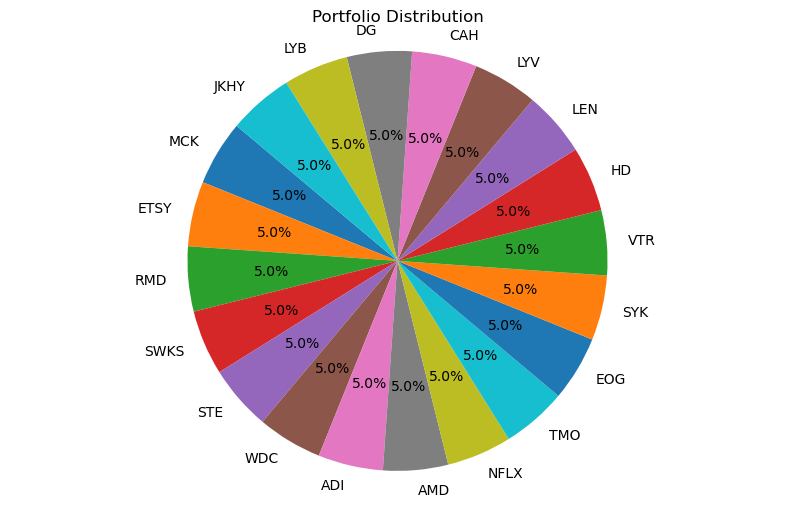

In [39]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Obtain a summary of the portfolio 
random_portfolio.summarize_portfolio()

# Visualize portfolio distribution 
random_portfolio.visualize_portfolio_distribution()


#### Optimizing the Portfolio 


--- Portfolio Summary After Optimization ---
Portfolio Summary:
Tickers: ['MCK', 'ETSY', 'RMD', 'SWKS', 'STE', 'WDC', 'ADI', 'AMD', 'NFLX', 'TMO', 'EOG', 'SYK', 'VTR', 'HD', 'LEN', 'LYV', 'CAH', 'DG', 'LYB', 'JKHY']
Weights: {'MCK': 0.0010594072079458583, 'ETSY': 0.024109970620082962, 'RMD': 0.04973306350829528, 'SWKS': 0.0006347474247563563, 'STE': 0.06666455290226506, 'WDC': 0.02981892589319593, 'ADI': 3.6327550130547076e-17, 'AMD': 2.3253821030096666e-16, 'NFLX': 0.014182379184902779, 'TMO': 2.906597317346158e-16, 'EOG': 0.13188751733269188, 'SYK': 0.09927798752336912, 'VTR': 0.1974606584725155, 'HD': 6.539745527870797e-17, 'LEN': 5.639762943636356e-16, 'LYV': 0.023173110095441252, 'CAH': 0.12103535219019927, 'DG': 0.10469211954777838, 'LYB': 1.4844885309642742e-16, 'JKHY': 0.13627020809655943}
Portfolio Expected Return: 0.003151009137792348
Portfolio Volatility: 0.012193083429058466
Portfolio Diversification Ratio: 2.7455843068283845
Portfolio Sharpe Ratio: 0.25842594747468767


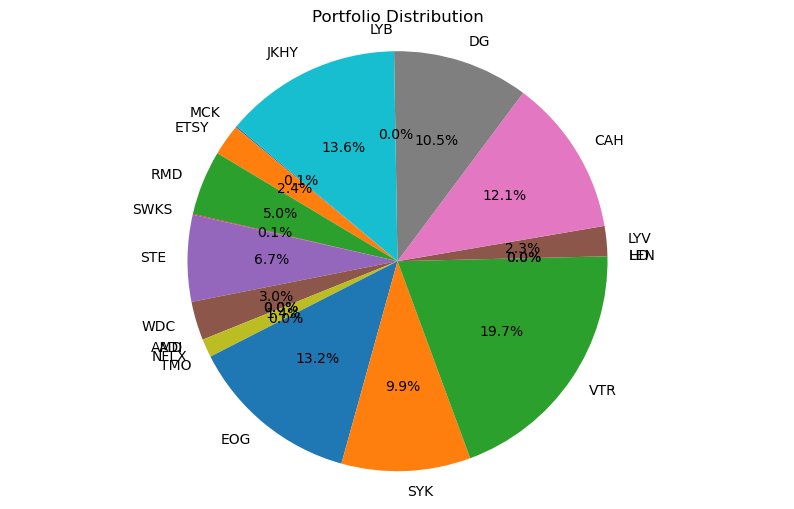

In [40]:
# Optimize portfolio weights 
random_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the portfolio after optimization
print("\n--- Portfolio Summary After Optimization ---")
random_portfolio.summarize_portfolio()

# Visualize the portfolio distribution after optimization
random_portfolio.visualize_portfolio_distribution()

#### Extracting Portfolio Embeddings

In [54]:
def diversify_betavae_portfolio(
    portfolio, 
    portfolio_embeddings, 
    all_returns, 
    all_stock_embeddings, 
    threshold=1e-3, 
    num_iter=20, 
    top_N=5, 
    distance_type="euclidean"
):
    """
    Diversify a portfolio based on embedding similarity and maximize diversification ratio.
    
    Parameters:
    - portfolio: Portfolio object.
    - portfolio_embeddings: Dictionary of portfolio ticker embeddings.
    - all_returns: Dictionary of tickers and their corresponding return vectors.
    - all_stock_embeddings: Dictionary of all stock embeddings.
    - threshold: Threshold for diversification ratio improvement.
    - num_iter: Maximum number of iterations.
    - top_N: Number of most dissimilar stocks to consider for replacement.
    - distance_type: Type of distance metric ("euclidean" or "cosine").
    
    Returns:
    - updated_portfolio: Updated Portfolio object.
    - diversification_history: List of diversification ratios at each step.
    - swap_log: Dictionary of removed tickers and their replacements.
    """
    # Deep copy the portfolio
    updated_portfolio = portfolio.copy_portfolio()
    
    # Calculate the initial diversification ratio
    initial_diversification_ratio = updated_portfolio.diversification_ratio
    current_diversification_ratio = initial_diversification_ratio
    
    # Exclude portfolio tickers from all_stock_embeddings
    excluded_tickers = set(updated_portfolio.tickers)
    available_tickers = {ticker: embedding for ticker, embedding in all_stock_embeddings.items() 
                         if ticker not in excluded_tickers}
    
    diversification_history = [initial_diversification_ratio]
    swap_log = {}
    
    print(f"Initial Diversification Ratio: {initial_diversification_ratio}")
    
    for _ in tqdm(range(num_iter), desc="Diversification Iterations"):
        # 3. Find the two most similar stocks in the portfolio
        tickers = list(portfolio_embeddings.keys())
        embeddings = np.array(list(portfolio_embeddings.values()))
        pairwise_distances = cdist(embeddings, embeddings, metric=distance_type)
        np.fill_diagonal(pairwise_distances, np.inf)  # Ignore self-similarity
        
        # Find the indices of the most similar pair
        i, j = np.unravel_index(np.argmin(pairwise_distances), pairwise_distances.shape)
        most_similar_pair = [tickers[i], tickers[j]]
        
        # 4. Pick one of these tickers at random
        ticker_to_replace = random.choice(most_similar_pair)
        ticker_embedding = portfolio_embeddings[ticker_to_replace]
        
        # Find top_N most dissimilar stocks from the universe
        all_embeddings = np.array(list(available_tickers.values()))
        distances_to_ticker = cdist([ticker_embedding], all_embeddings, metric=distance_type).flatten()
        top_dissimilar_indices = np.argsort(distances_to_ticker)[-top_N:]
        top_dissimilar_tickers = [list(available_tickers.keys())[idx] for idx in top_dissimilar_indices]
        
        # Choose one of these tickers at random
        replacement_ticker = random.choice(top_dissimilar_tickers)
        replacement_returns = all_returns[replacement_ticker]  # Correctly fetch return vectors
        
        # 5. Swap the tickers and update the portfolio
        add_tickers = {replacement_ticker: replacement_returns}
        remove_tickers = [ticker_to_replace]
        
        # Temporarily update the portfolio
        updated_portfolio.update_portfolio(add_tickers=add_tickers, remove_tickers=remove_tickers)
        updated_portfolio.optimize_weights(method="max_div", update_weights=True)
        
        # 6. Calculate new diversification ratio
        new_diversification_ratio = updated_portfolio.diversification_ratio
        
        # 7. Accept or reject the swap
        if new_diversification_ratio > current_diversification_ratio:
            current_diversification_ratio = new_diversification_ratio
            diversification_history.append(current_diversification_ratio)
            excluded_tickers.add(ticker_to_replace)
            available_tickers.pop(replacement_ticker)
            swap_log[ticker_to_replace] = replacement_ticker
            
            print(f"Accepted Swap: {ticker_to_replace} -> {replacement_ticker}")
            print(f"New Diversification Ratio: {new_diversification_ratio}")
            
            # Update portfolio embeddings
            portfolio_embeddings.pop(ticker_to_replace)
            portfolio_embeddings[replacement_ticker] = all_stock_embeddings[replacement_ticker]
        else:
            # Reject the swap and revert changes
            updated_portfolio.update_portfolio(
                add_tickers={ticker_to_replace: portfolio.raw_returns[ticker_to_replace]},
                remove_tickers=[replacement_ticker]
            )
            print(f"Rejected Swap: {ticker_to_replace} -> {replacement_ticker}")
        
        # Check for convergence
        if abs(new_diversification_ratio - current_diversification_ratio) < threshold:
            print("Convergence reached.")
            break
    
    return updated_portfolio, diversification_history, swap_log


In [64]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Generate embeddings for the stock data (full universe of data)
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Extract embeddings from Portfolio  
random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                               if ticker in stock_embeddings.keys()}

# Check that number of extracted embeddings == number of portfolio tickers
assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)

In [65]:
# Apply the diversify function to the random portfolio
updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
    random_portfolio,
    random_portfolio_embeddings,
    all_returns,
    stock_embeddings,
    num_iter=20,
    top_N=5,
    threshold=1e-4,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio.diversification_ratio)
print("Diversification History:", diversification_history)
print("Swap Log (Removed -> Added):", swap_log)


Initial Diversification Ratio: 2.333219984004402


Diversification Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Accepted Swap: CSGP -> BA
New Diversification Ratio: 3.0925186754979896
Convergence reached.

Final Diversification Ratio: 3.0925186754979896
Diversification History: [2.333219984004402, 3.0925186754979896]
Swap Log (Removed -> Added): {'CSGP': 'BA'}


In [66]:
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

Portfolio Summary:
Tickers: ['TFX', 'RTX', 'AMZN', 'AON', 'KVUE', 'CB', 'CHD', 'MNST', 'PEG', 'EOG', 'IBM', 'CCI', 'AZO', 'WDC', 'APA', 'CI', 'CSGP', 'VST', 'AIG', 'LLY']
Weights: {'TFX': 0.05, 'RTX': 0.05, 'AMZN': 0.05, 'AON': 0.05, 'KVUE': 0.05, 'CB': 0.05, 'CHD': 0.05, 'MNST': 0.05, 'PEG': 0.05, 'EOG': 0.05, 'IBM': 0.05, 'CCI': 0.05, 'AZO': 0.05, 'WDC': 0.05, 'APA': 0.05, 'CI': 0.05, 'CSGP': 0.05, 'VST': 0.05, 'AIG': 0.05, 'LLY': 0.05}
Portfolio Expected Return: 0.004948410241729159
Portfolio Volatility: 0.015554105246618141
Portfolio Diversification Ratio: 2.333219984004402
Portfolio Sharpe Ratio: 0.31814174864253725


In [67]:
# Optimize the updated portfolio weights with max_div 
updated_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio.summarize_portfolio()

Portfolio Summary:
Tickers: ['TFX', 'RTX', 'AMZN', 'AON', 'KVUE', 'CB', 'CHD', 'MNST', 'PEG', 'EOG', 'IBM', 'CCI', 'AZO', 'WDC', 'APA', 'CI', 'VST', 'AIG', 'LLY', 'BA']
Weights: {'TFX': 0.10662083330210113, 'RTX': 0.0144381140170283, 'AMZN': 0.08384531342719553, 'AON': 0.09504094045990334, 'KVUE': 0.0, 'CB': 0.0, 'CHD': 0.2914909155229972, 'MNST': 0.028414544504099734, 'PEG': 0.08347284910976704, 'EOG': 0.059805689341942074, 'IBM': 0.0, 'CCI': 0.023661324289160412, 'AZO': 0.06081725828128093, 'WDC': 0.0, 'APA': 0.06550611770719819, 'CI': 0.008147004942124527, 'VST': 2.2998638583848763e-16, 'AIG': 1.6094704715415443e-17, 'LLY': 0.04551966038431521, 'BA': 0.03321943471088703}
Portfolio Expected Return: 0.0024742571683311447
Portfolio Volatility: 0.009884061732462573
Portfolio Diversification Ratio: 3.0925186754979896
Portfolio Sharpe Ratio: 0.2503279760186902
